# Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Embedding, LSTM, Dropout, BatchNormalization, Dense, concatenate, Flatten, Conv1D
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras import regularizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
%matplotlib inline
import re
import pickle
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

Using TensorFlow backend.


In [0]:
#clearing the graph of tensorflow
tf.keras.backend.clear_session()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive/data

/content/drive/My Drive/data


In [5]:
df = pd.read_csv("preprocessed_data.csv")

df.shape

(109248, 9)

In [6]:
df.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [0]:
from sklearn.model_selection import train_test_split
x=df.drop(['project_is_approved'],axis=1)
y=df['project_is_approved']

x_train,x_test,y_train,y_test=train_test_split(x, y, test_size = 0.3,stratify = y)
x_train,x_cv,y_train,y_cv=train_test_split(x_train, y_train, test_size = 0.3,stratify = y_train)

In [8]:
print(x_train.shape)
print(x_cv.shape)
print(x_test.shape)

(53531, 8)
(22942, 8)
(32775, 8)


In [9]:
#counting unique words in the 'essay' column and maximum essay length
corpus=[]
essay_len=[]
ctr=0
for sent in x_train['essay'].values:
  ctr=0
  for word in sent.split():
    corpus.append(word)
    ctr+=1
  essay_len.append(ctr)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 339
No of unique words  42940


In [0]:
# encoding each word to an integer value
token = Tokenizer()
token.fit_on_texts(x_train["essay"])
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [11]:
#padding the train and test data (essay column)
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (53531, 339)


In [12]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (22942, 339)


In [14]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape of padded_essay_test', padded_essay_test.shape)

Shape of padded_essay_test (32775, 339)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors.txt', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [17]:
len(token.word_index)

42940

In [18]:
embedding_matrix.shape

(42941, 300)

In [0]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.InteractiveSession()

In [20]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
#INPUT LAYER
input_layer = Input(shape=(max_len,))
#EMBEDDING LAYER
embedding =embedding_layer(input_layer)
#LSTM LAYER
x = LSTM(100, return_sequences=True)(embedding)
#Flattening the data
flatten = Flatten()(x)

In [24]:
no_of_state  = x_train["school_state"].nunique()
print('Unique State:', no_of_state)

Unique State: 51


In [0]:
input_state = Input(shape=(1,))
embedding = Embedding(no_of_state,5,trainable=True)(input_state)
flatten_1=Flatten()(embedding)


In [26]:
no_of_grade  = x_train["project_grade_category"].nunique()
print('Unique Grades:', no_of_grade)

Unique Grades: 4


In [0]:
input_grade = Input(shape=(1,))
embedding = Embedding(no_of_state,5,trainable=True)(input_grade)
flatten_2=Flatten()(embedding)


In [28]:
no_of_prefix  = x_train["teacher_prefix"].nunique()
print('Unique Prefixes ', no_of_prefix)

Unique Prefixes  5


In [0]:
input_pre = Input(shape=(1,))
embedding = Embedding(no_of_state,5,trainable=True)(input_pre)
flatten_3=Flatten()(embedding)


In [30]:
no_of_cat  = x_train["clean_categories"].nunique()
print('Unique Categories ', no_of_cat)

Unique Categories  50


In [0]:
input_cat= Input(shape=(1,))
embedding = Embedding(no_of_state,5,trainable=True)(input_cat)
flatten_4=Flatten()(embedding)

In [32]:
no_of_sub  = x_train["clean_subcategories"].nunique()
print('Unique SubCategories ', no_of_sub)

Unique SubCategories  379


In [0]:
input_sub = Input(shape=(1,))
embedding = Embedding(no_of_state,5,trainable=True)(input_sub)
flatten_5=Flatten()(embedding)


In [0]:
#concatenating 2 numerical features 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
Input_num = Input(shape=(2,))
#rem_input = Dense(100,activation="relu",kernel_initializer="he_normal", kernel_regularizer=regularizers.l2(0.001))(Input_num)
rem_input = Dense(100,activation="relu",kernel_initializer="he_uniform")(Input_num)

In [0]:
#Converting Categorical data into numerical indices
lb = LabelEncoder()
padded_pre_train = lb.fit_transform(x_train["teacher_prefix"])
padded_pre_test = lb.transform(x_test["teacher_prefix"])
padded_pre_cv = lb.transform(x_cv["teacher_prefix"])

In [0]:
padded_st_train = lb.fit_transform(x_train["school_state"])
padded_st_test = lb.transform(x_test["school_state"])
padded_st_cv = lb.transform(x_cv["school_state"])

In [0]:
padded_grade_train = lb.fit_transform(x_train["project_grade_category"])
padded_grade_test = lb.transform(x_test["project_grade_category"])
padded_grade_cv = lb.transform(x_cv["project_grade_category"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_categories"])
x_test["clean_categories"] = x_test["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_categories"] = x_cv["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_cat_train = le.transform(x_train["clean_categories"])
padded_cat_test= le.transform(x_test["clean_categories"])
padded_cat_cv = le.transform(x_cv["clean_categories"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_subcategories"])
x_test["clean_subcategories"] = x_test["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_subcategories"] = x_cv["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_sub_train = le.transform(x_train["clean_subcategories"])
padded_sub_test= le.transform(x_test["clean_subcategories"])
padded_sub_cv = le.transform(x_cv["clean_subcategories"])

In [0]:
padded_data_train = [padded_essay_train,padded_pre_train,padded_st_train,
              padded_grade_train,padded_cat_train,padded_sub_train,num_train]
padded_data_test = [padded_essay_test,padded_pre_test,padded_st_test,
              padded_grade_test,padded_cat_test,padded_sub_test,num_test]
padded_data_cv = [padded_essay_cv,padded_pre_cv,padded_st_cv,
              padded_grade_cv,padded_cat_cv,padded_sub_cv,num_cv]

In [0]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 2) 
y_cv=np_utils.to_categorical(y_cv, 2) 
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
#https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
  
# try:
#     roc_auc_score(y_true, y_scores)
# except ValueError:
#     pass

In [46]:
print("Building Model-1")
x_concatenate = concatenate([flatten,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,rem_input])
x = Dense(128, activation='relu',kernel_initializer="he_uniform")(x_concatenate)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu',kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',kernel_initializer="he_uniform")(x)
output = Dense(2, activation='softmax', name='output')(x)
model_1 = Model(inputs=[input_layer,input_state,input_grade,input_pre,input_cat,input_sub,Input_num],outputs=[output])

Building Model-1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
#Printing Model Summary
print(model_1.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 339)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 339, 300)     12882300    input_1[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

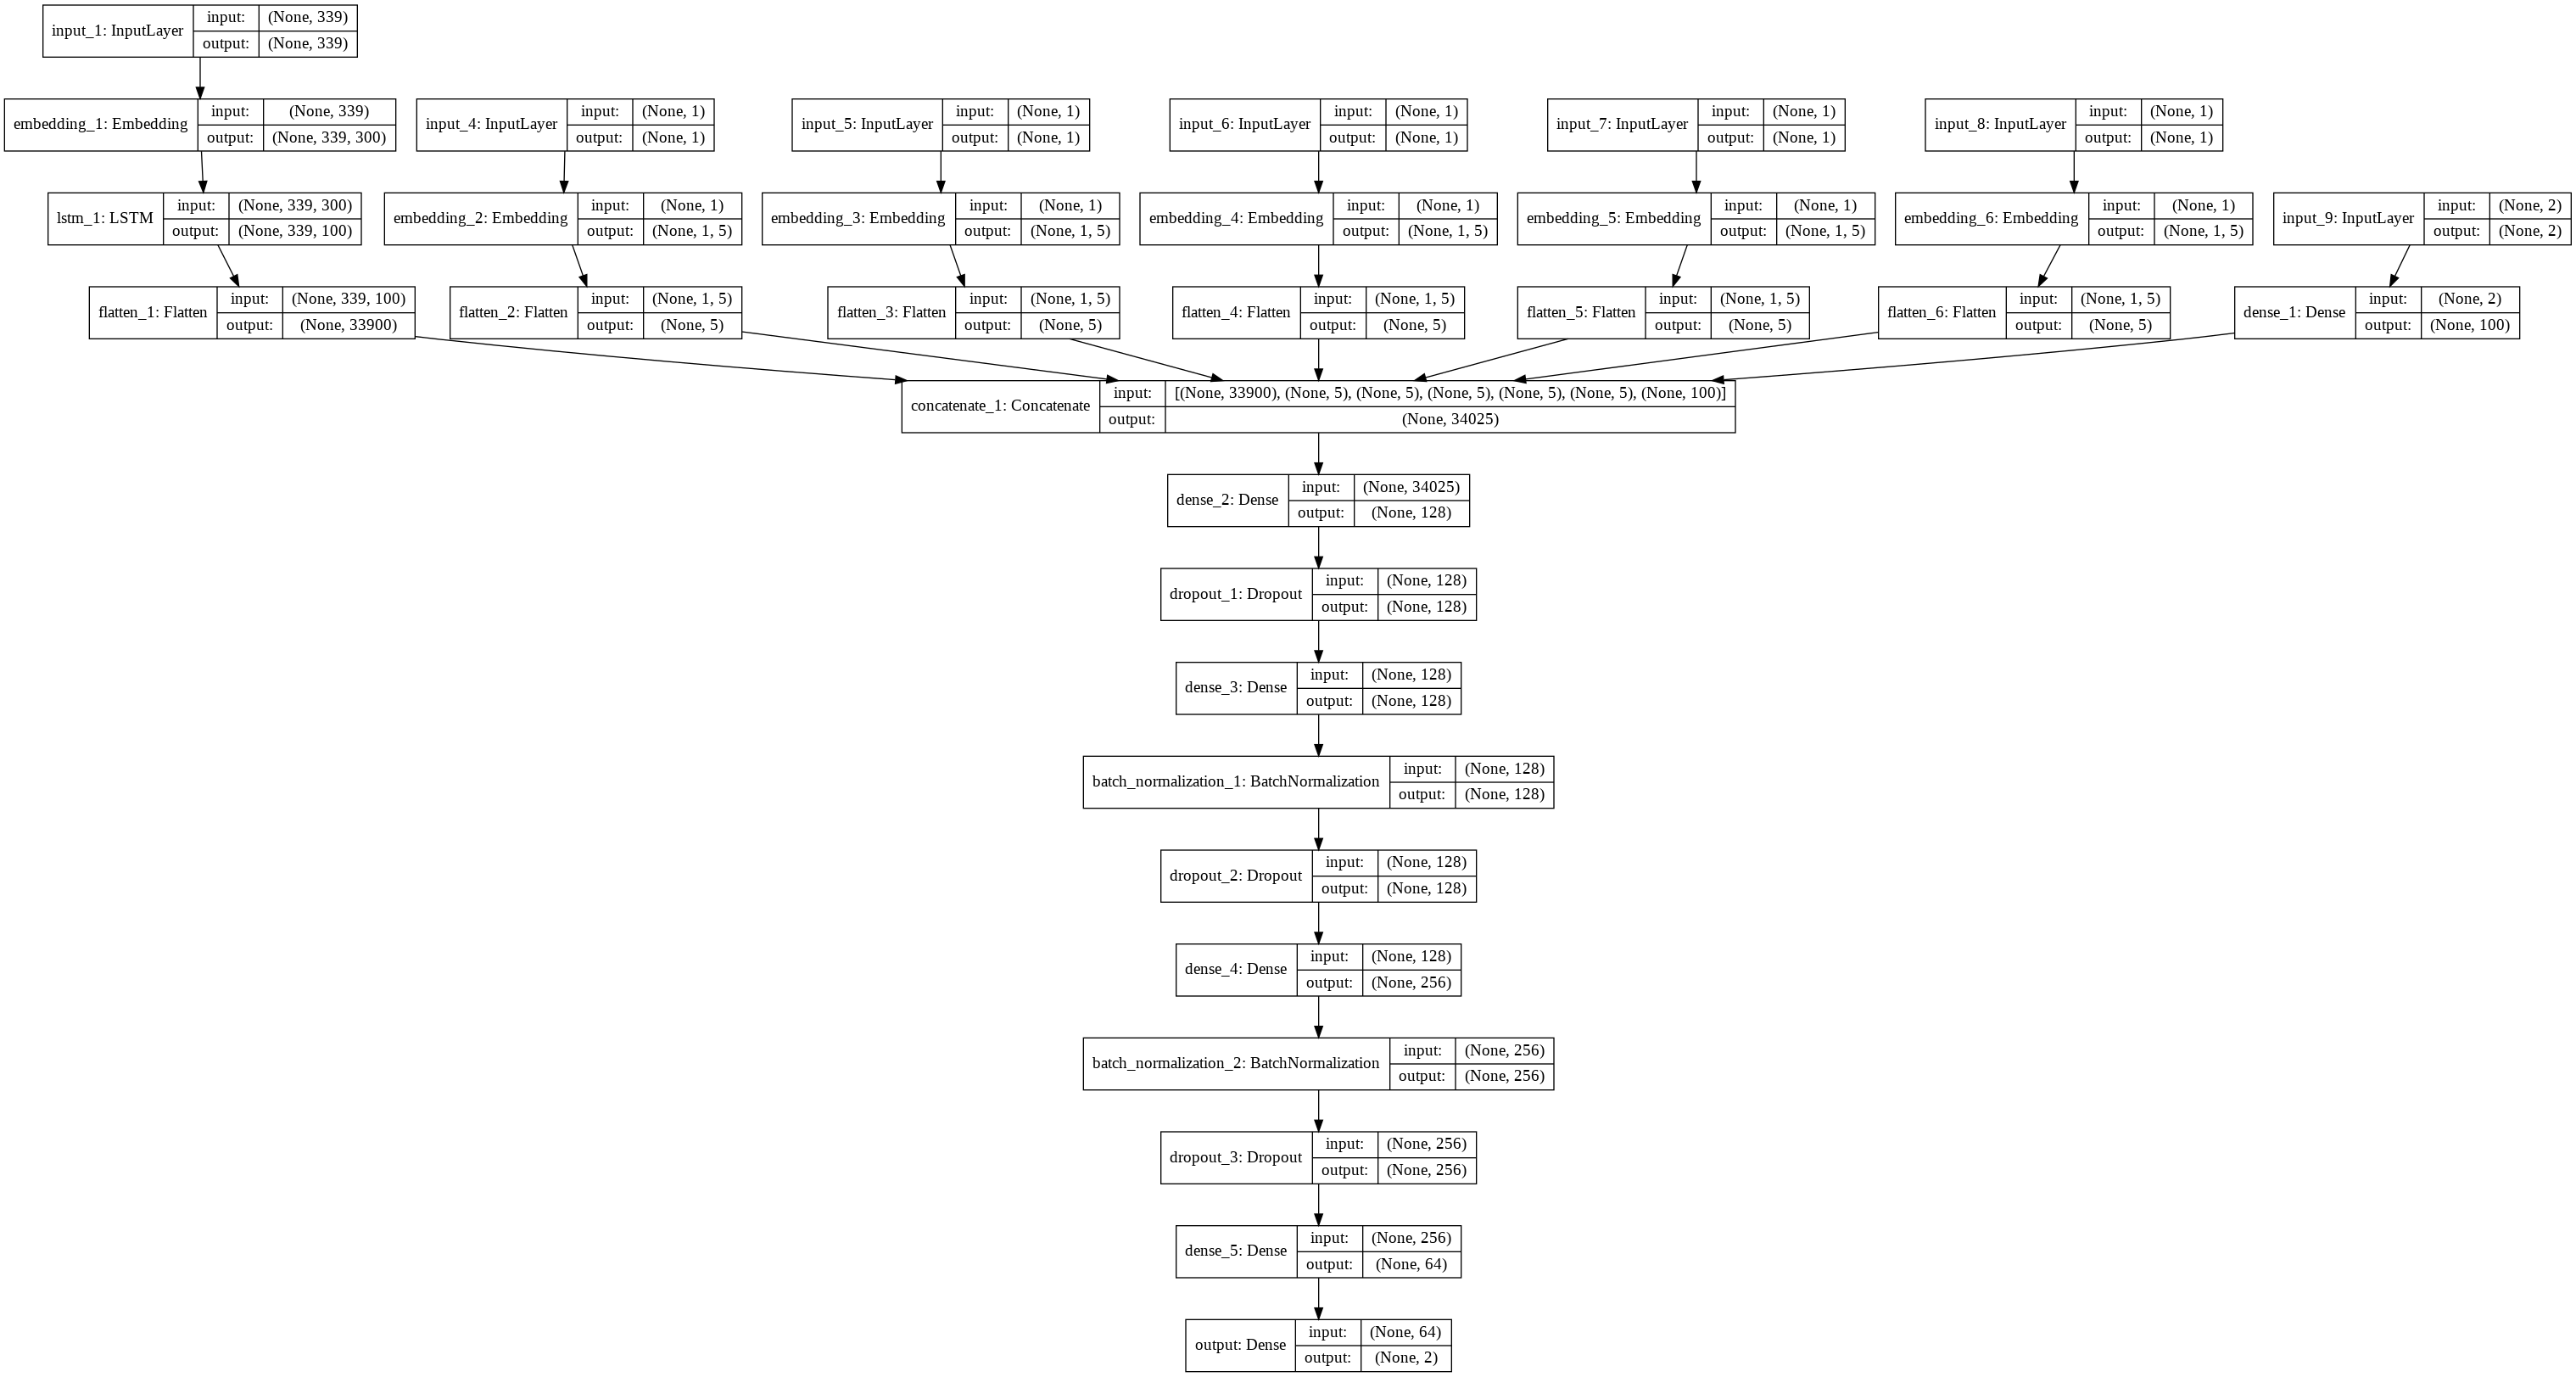

In [48]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [57]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

tensorboard_1 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_1 = ModelCheckpoint("model_1.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb1=[tensorboard_1,checkpoint_1]

In [59]:
trained_model = model_1.fit(padded_data_train,y_train,batch_size=512,epochs=20,validation_data=(padded_data_cv,y_cv),callbacks=callb1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 53531 samples, validate on 22942 samples



Epoch 1/20
53531/53531 [==============================] - 89s 2ms/step - loss: 0.5413 - auc: 0.5170 - val_loss: 0.4288 - val_auc: 0.5720

Epoch 00001: auc improved from -inf to 0.51704, saving model to model_1.h5
Epoch 2/20
53531/53531 [==============================] - 88s 2ms/step - loss: 0.4569 - auc: 0.5376 - val_loss: 0.4841 - val_auc: 0.6512

Epoch 00002: auc improved from 0.51704 to 0.53760, saving model to model_1.h5
Epoch 3/20
53531/53531 [==============================] - 88s 2ms/step - loss: 0.4280 - auc: 0.6175 - val_loss: 0.4071 - val_auc: 0.6897

Epoch 00003: auc improved from 0.53760 to 0.61749, saving model to model_1.h5
Epoch 4/20
53531/53531 [==============================] - 88s 2ms/step - loss: 0.4070 - auc: 0.6769 - val_loss: 0.4998 - val_auc: 0.7247

Epoch 00004: auc improved from 0.61749 to 0.67694, saving model to mod

In [60]:
model_1.metrics_names

['loss', 'auc']

In [61]:
try:
  score = model_1.evaluate(padded_data_test, y_test, verbose=1,batch_size=512) 
  print('Test Loss:', score[0]) 
  print('Test AUC:', score[1])
except ValueError:
       pass

32775/32775 [==============================] - 19s 578us/step
Test Loss: 0.5331925583613183
Test AUC: 0.7631720415784016


## TEST AUC: 0.76

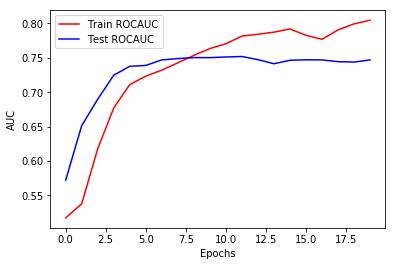

In [62]:
plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

In [0]:
#!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

In [0]:
%tensorboard --logdir direc

## GRAPHS FROM TENSORBOARD:-

In [0]:
from IPython.display import Image

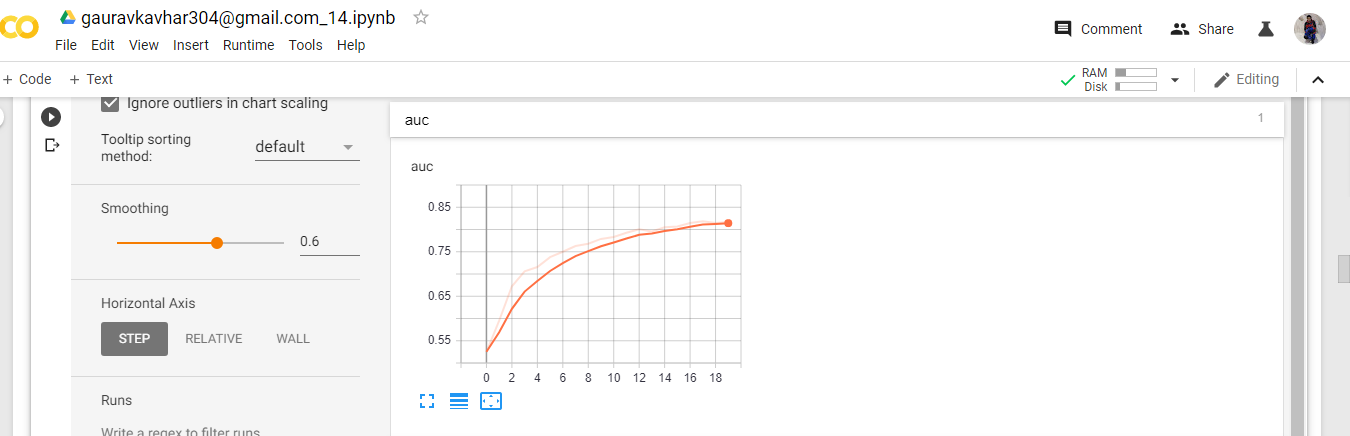

In [14]:
Image('auc.png')

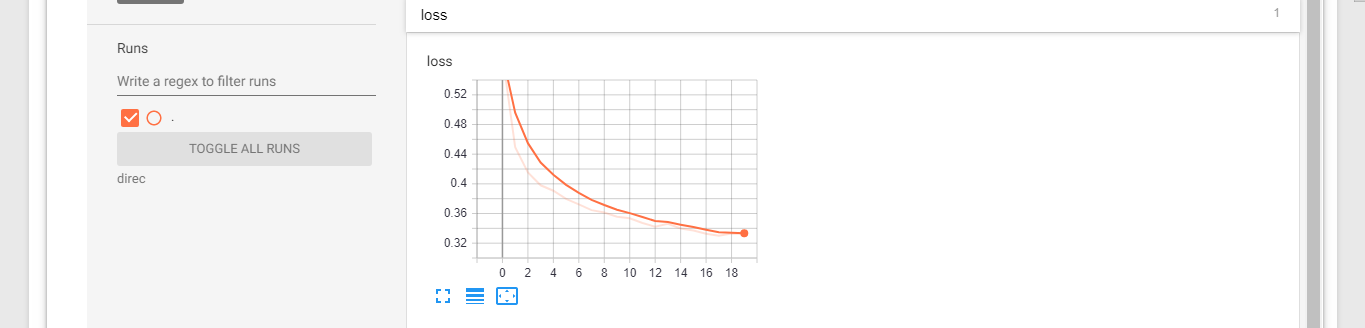

In [9]:
Image('loss1.png')

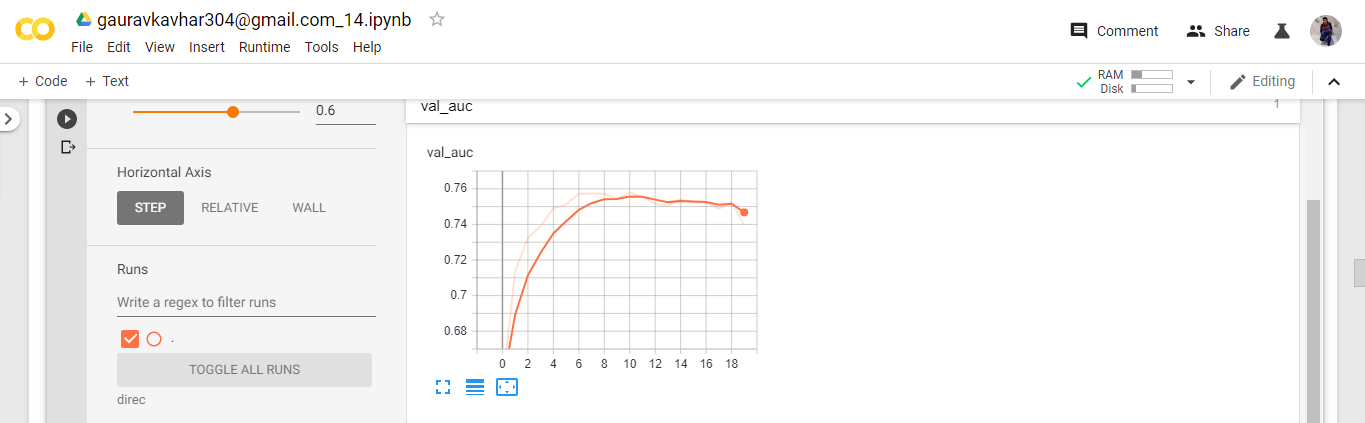

In [15]:
Image('val1.png')

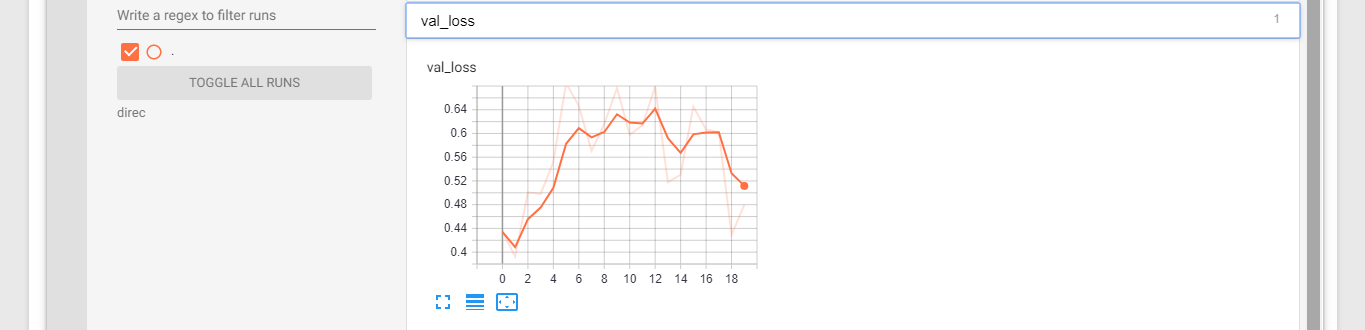

In [16]:
Image('valloss1.png')

# Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data feature 'essay' <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10)
text_tfidf_train = vectorizer_tfidf_essay.fit_transform(x_train['essay'])
text_tfidf_test = vectorizer_tfidf_essay.transform(x_test['essay'])
text_tfidf_cv = vectorizer_tfidf_essay.transform(x_cv['essay'])
print("Shape of matrix after tf-idf encoding ",text_tfidf_train.shape)
print("Shape of matrix after tf-idf encoding ",text_tfidf_test.shape)
print("Shape of matrix after tf-idf encoding ",text_tfidf_cv.shape)

Shape of matrix after tf-idf encoding  (53531, 12600)
Shape of matrix after tf-idf encoding  (32775, 12600)
Shape of matrix after tf-idf encoding  (22942, 12600)


In [0]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(vectorizer_tfidf_essay.get_feature_names(), list(vectorizer_tfidf_essay.idf_)))

In [58]:
import operator
sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1))
len(sorted_x)

12600

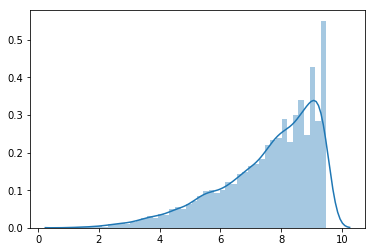

In [59]:
d=[]
for i in sorted_x:
    d.append(i[1])
np.array(d).astype(np.float)
sns.distplot(d, hist=True, kde=True)
             

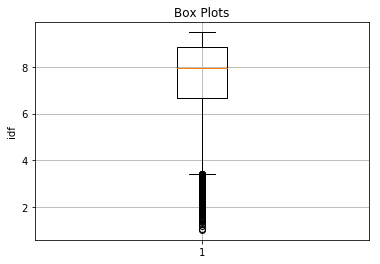

In [60]:
plt.boxplot(d)
plt.title('Box Plots')
plt.xlabel('')
plt.ylabel('idf')
plt.grid()
plt.show()

In [0]:
vocab=[]
for i in sorted_x:
    if (i[1]>6 and i[1]<11):
        vocab.append(i[0])

In [64]:
new_essay=[]
for sen in tqdm(x_train['essay'].values):
    sentence=list()
    words=sen.split()
    for word in words:
        if  word in vocab:
            sentence.append(word)
    new=' '.join(sentence)
    new_essay.append(new)

100%|██████████| 53531/53531 [09:28<00:00, 94.15it/s] 


In [65]:
new_essay=np.array(new_essay)
corpus=[]
essay_len=[]
cnt=0
for sen in new_essay:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 290
No of unique words  12575


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(new_essay)
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [67]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (53531, 290)


In [68]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (32775, 290)


In [69]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (22942, 290)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors.txt', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [0]:
tf.keras.backend.clear_session()

In [0]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding =embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

In [75]:
no_of_unique_state  = x_train["school_state"].nunique()
print('Unique State:', no_of_unique_state)

Unique State: 51


In [0]:
input_state = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_state)
flatten_1=Flatten()(embedding)


In [77]:
no_of_unique_grade  = x_train["project_grade_category"].nunique()
print('Unique Grades:', no_of_unique_grade)

Unique Grades: 4


In [0]:
input_grade = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_grade)
flatten_2=Flatten()(embedding)


In [79]:
no_of_unique_prefix  = x_train["teacher_prefix"].nunique()
print('Unique Prefixes ', no_of_unique_prefix)

Unique Prefixes  5


In [0]:
input_pre = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_pre)
flatten_3=Flatten()(embedding)


In [81]:
no_of_unique_cat  = x_train["clean_categories"].nunique()
print('Unique Categories ', no_of_unique_cat)

Unique Categories  50


In [0]:
input_cat= Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_cat)
flatten_4=Flatten()(embedding)

In [83]:
no_of_unique_sub  = x_train["clean_subcategories"].nunique()
print('Unique SubCategories ', no_of_unique_sub)

Unique SubCategories  379


In [0]:
input_sub = Input(shape=(1,))
embedding = Embedding(no_of_unique_state,5,trainable=True)(input_sub)
flatten_5=Flatten()(embedding)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
Input_num = Input(shape=(2,))
rem_input = Dense(100,activation="relu",kernel_initializer="he_uniform")(Input_num)

In [89]:
print("Building Model-2")
x_concatenate = concatenate([flatten,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,rem_input])
x = Dense(128, activation='relu',kernel_initializer="he_uniform")(x_concatenate)
x=Dropout(0.5)(x)
x = Dense(256, activation='relu',kernel_initializer="he_uniform")(x)
x=Dropout(0.5)(x)
x = Dense(64, activation='relu',kernel_initializer="he_uniform")(x)
output = Dense(2, activation='softmax', name='output')(x)
model_2 = Model(inputs=[input_layer,input_state,input_grade,input_pre,input_cat,input_sub,Input_num],outputs=[output])

Building Model-2


In [90]:
#Printing Model Summary
print(model_2.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 290)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 290, 300)     3772800     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
____________________________________________________________________________________________

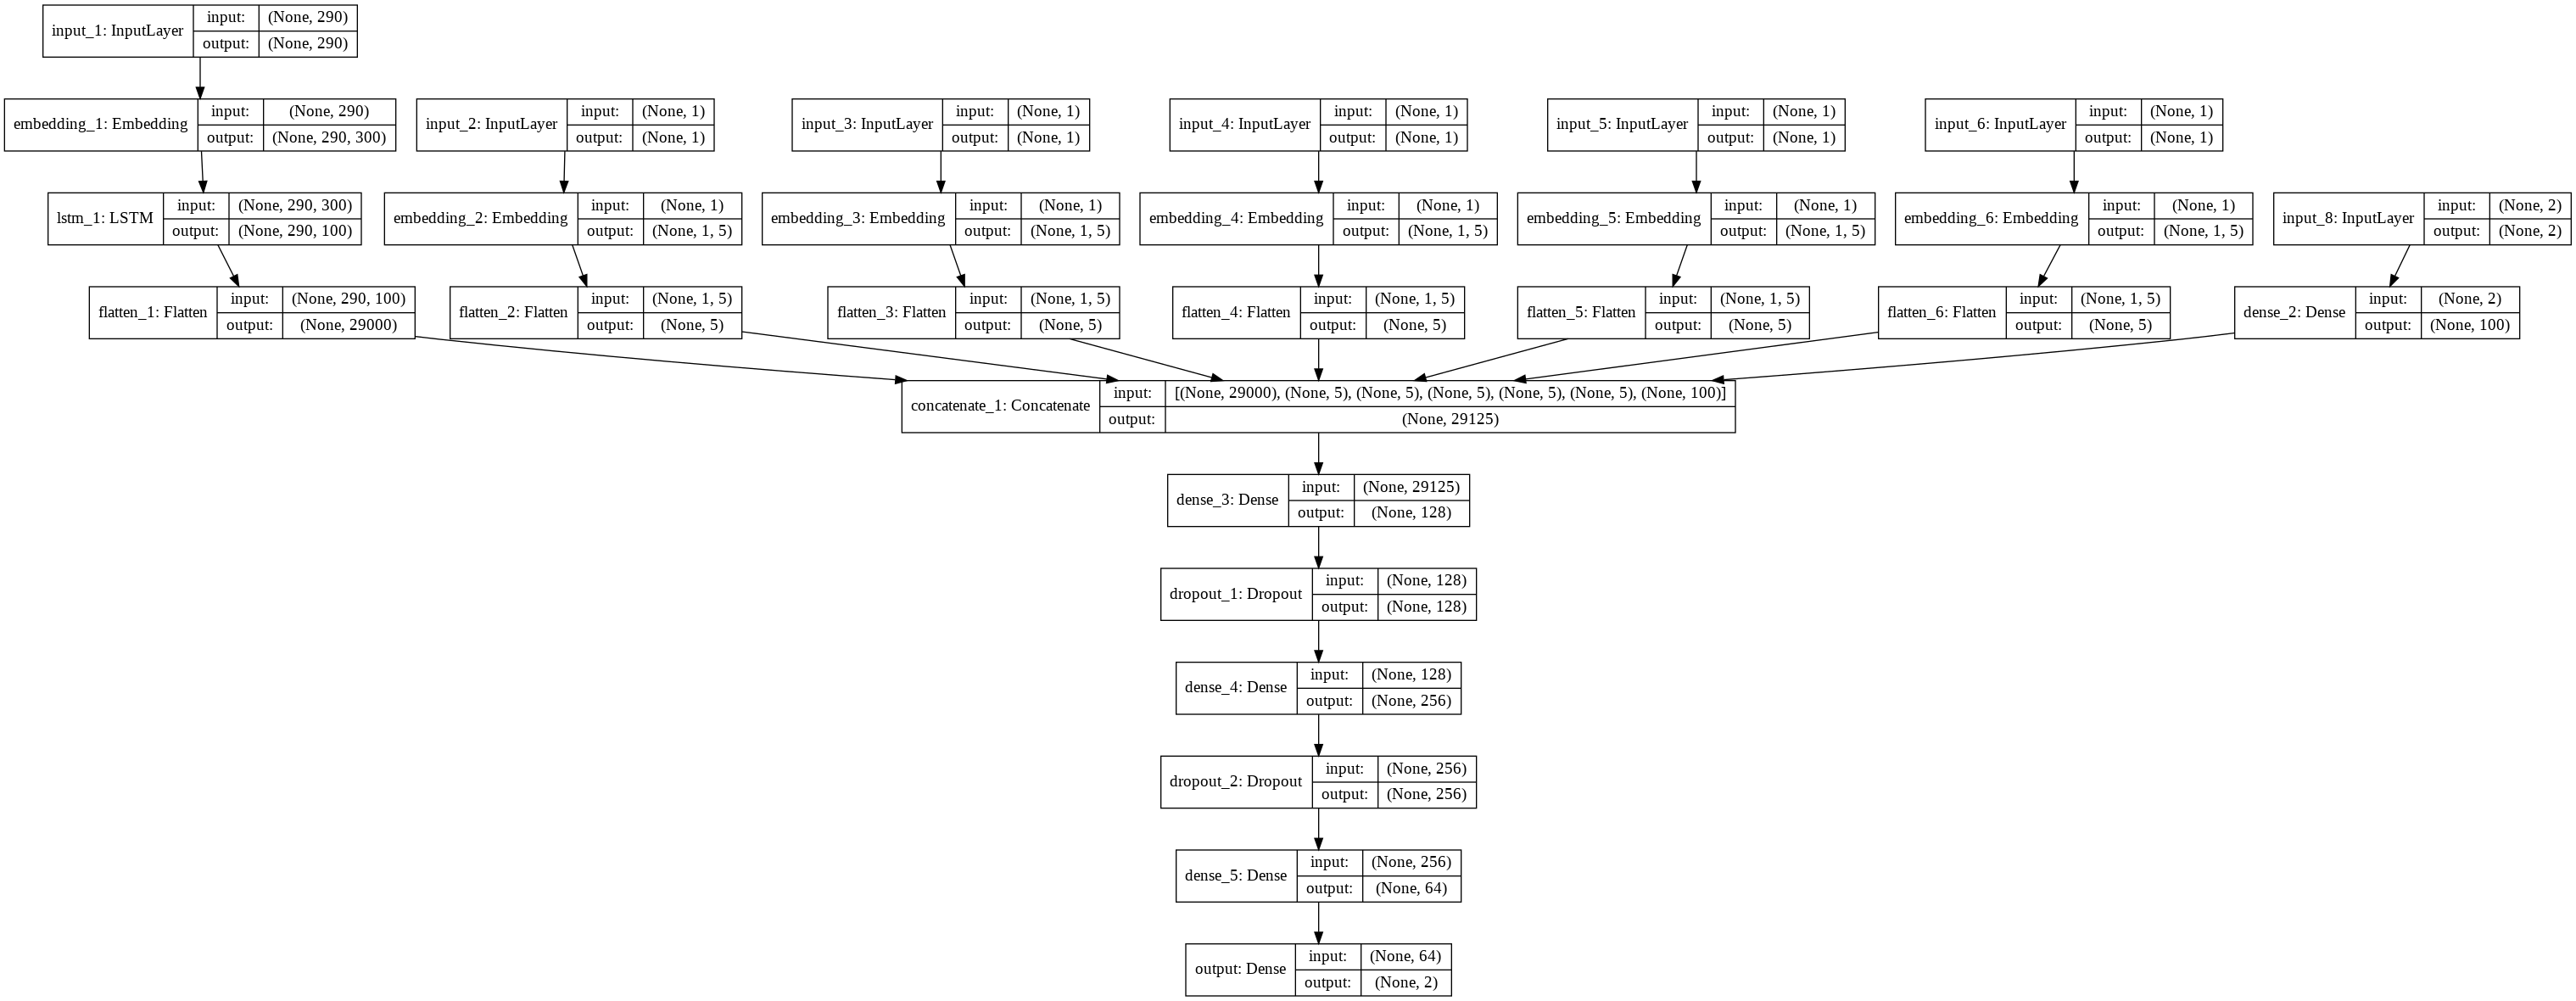

In [91]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [0]:
#Use to convert categorical data into numerical indexes
lb = LabelEncoder()
padded_pre_train = lb.fit_transform(x_train["teacher_prefix"])
padded_pre_test = lb.transform(x_test["teacher_prefix"])
padded_pre_cv = lb.transform(x_cv["teacher_prefix"])

In [0]:
padded_st_train = lb.fit_transform(x_train["school_state"])
padded_st_test = lb.transform(x_test["school_state"])
padded_st_cv = lb.transform(x_cv["school_state"])

In [0]:
padded_grade_train = lb.fit_transform(x_train["project_grade_category"])
padded_grade_test = lb.transform(x_test["project_grade_category"])
padded_grade_cv = lb.transform(x_cv["project_grade_category"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_categories"])
x_test["clean_categories"] = x_test["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_categories"] = x_cv["clean_categories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_cat_train = le.transform(x_train["clean_categories"])
padded_cat_test= le.transform(x_test["clean_categories"])
padded_cat_cv = le.transform(x_cv["clean_categories"])

In [0]:
#https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values
le = LabelEncoder()
le.fit(x_train["clean_subcategories"])
x_test["clean_subcategories"] = x_test["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
x_cv["clean_subcategories"] = x_cv["clean_subcategories"].map(lambda s: '<unknown>' if s not in le.classes_ else s)
le.classes_ = np.append(le.classes_, '<unknown>')
padded_sub_train = le.transform(x_train["clean_subcategories"])
padded_sub_test= le.transform(x_test["clean_subcategories"])
padded_sub_cv = le.transform(x_cv["clean_subcategories"])

In [0]:
padded_data_train = [padded_essay_train,padded_pre_train,padded_st_train,
              padded_grade_train,padded_cat_train,padded_sub_train,num_train]
padded_data_test = [padded_essay_test,padded_pre_test,padded_st_test,
              padded_grade_test,padded_cat_test,padded_sub_test,num_test]
padded_data_cv = [padded_essay_cv,padded_pre_cv,padded_st_cv,
              padded_grade_cv,padded_cat_cv,padded_sub_cv,num_cv]

In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

earlystop_2 = EarlyStopping(monitor = 'val_loss', mode="min",min_delta = 0, patience = 2,verbose = 1,restore_best_weights = True)
tensorboard_2 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_2 = ModelCheckpoint("model_2.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb2=[tensorboard_2,checkpoint_2,earlystop_2]

In [0]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

In [101]:
trained_model = model_2.fit(padded_data_train,y_train,batch_size=512,epochs=20,validation_data=(padded_data_cv,y_cv),callbacks=callb2)

Train on 53531 samples, validate on 22942 samples
Epoch 1/20
53531/53531 [==============================] - 76s 1ms/step - loss: 0.4355 - auc: 0.6354 - val_loss: 0.4514 - val_auc: 0.7081

Epoch 00001: auc improved from -inf to 0.63545, saving model to model_2.h5
Epoch 2/20
53531/53531 [==============================] - 76s 1ms/step - loss: 0.4155 - auc: 0.6707 - val_loss: 0.4239 - val_auc: 0.7285

Epoch 00002: auc improved from 0.63545 to 0.67073, saving model to model_2.h5
Epoch 3/20
53531/53531 [==============================] - 76s 1ms/step - loss: 0.3905 - auc: 0.7165 - val_loss: 0.4007 - val_auc: 0.7410

Epoch 00003: auc improved from 0.67073 to 0.71652, saving model to model_2.h5
Epoch 4/20
53531/53531 [==============================] - 76s 1ms/step - loss: 0.3826 - auc: 0.7351 - val_loss: 0.4330 - val_auc: 0.7415

Epoch 00004: auc improved from 0.71652 to 0.73513, saving model to model_2.h5
Epoch 5/20
53531/53531 [==============================] - 76s 1ms/step - loss: 0.3759 - a

32775/32775 [==============================] - 16s 497us/step
Test Loss: 0.4012673024000056
Test AUC: 0.7387510148670424


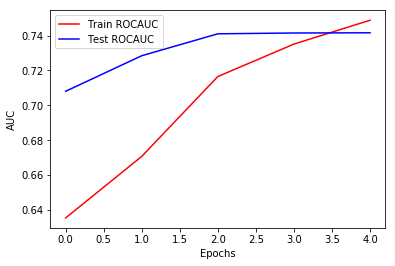

In [102]:
score = model_2.evaluate(padded_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

## TEST AUC: 0.74

In [0]:
!kill 3397

In [0]:
%tensorboard --logdir direc

## GRAPHS FROM TENSORBOARD:-

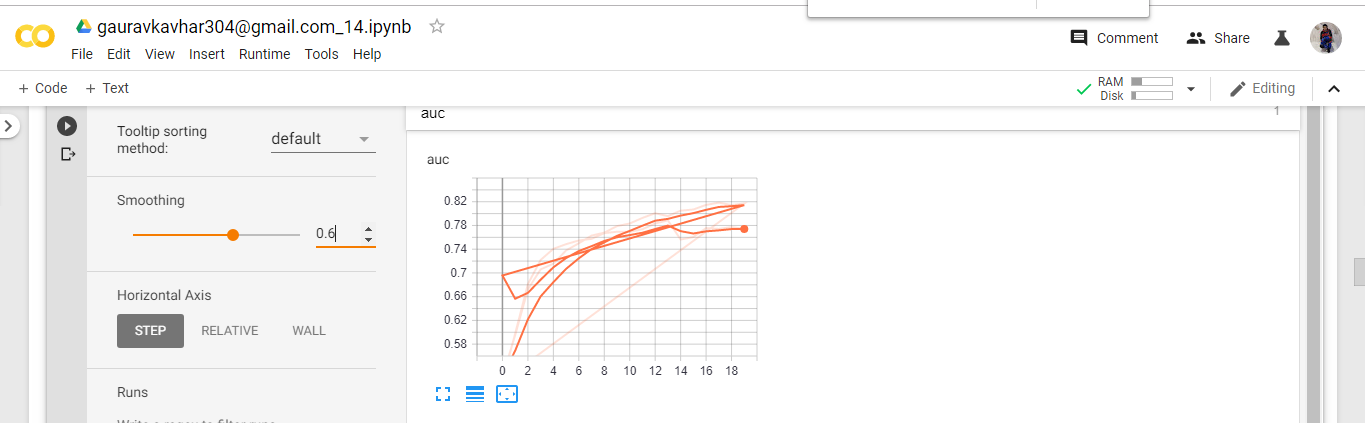

In [18]:
Image('auc2.png')

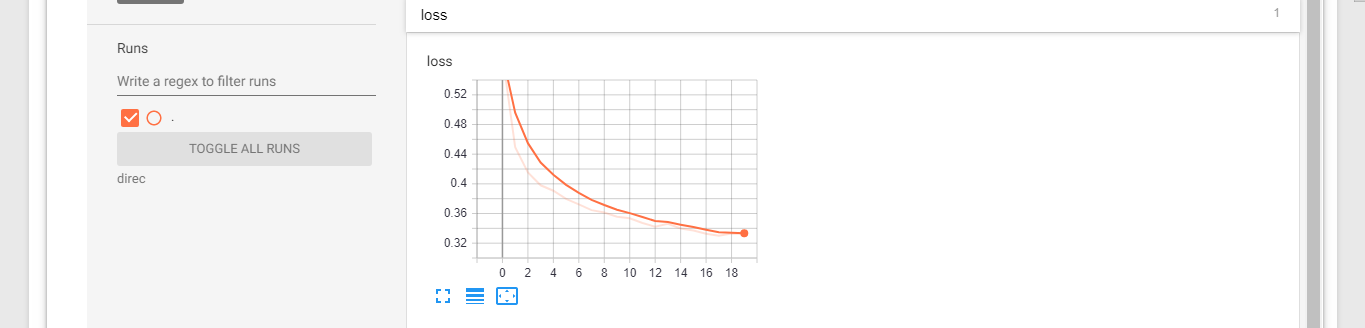

In [19]:
Image('loss1.png')

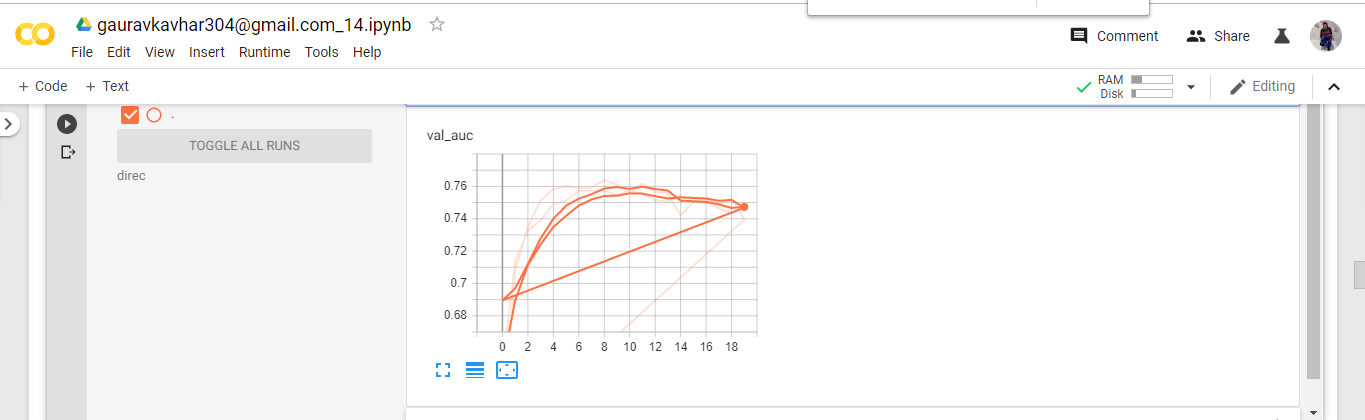

In [21]:
Image('val2.png')

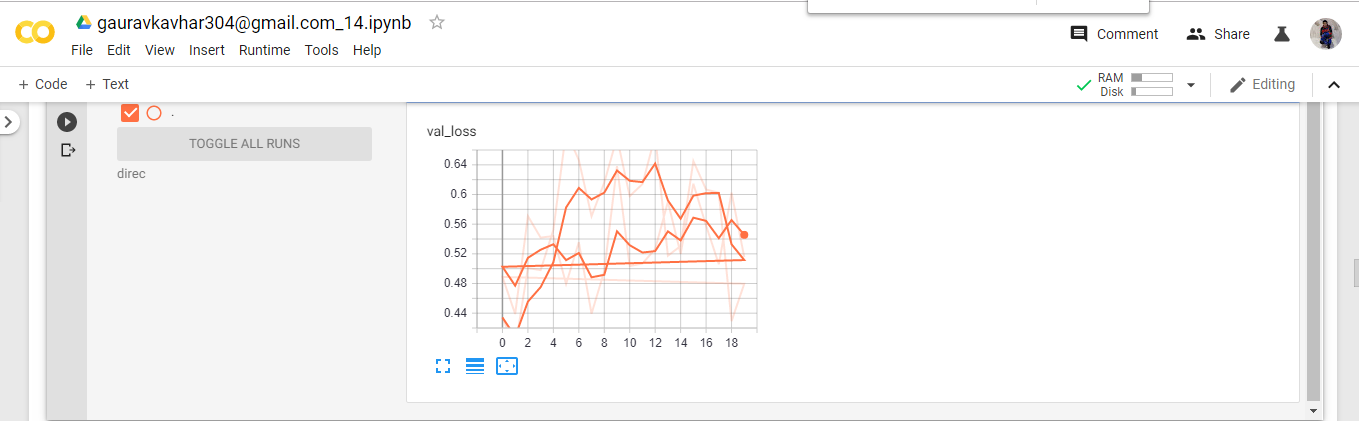

In [22]:
Image('valloss2.png')

# Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [109]:
corpus=[]
essay_len=[]
cnt=0
for sen in x_train['essay'].values:
  cnt=0
  for word in sen.split():
    corpus.append(word)
    cnt=cnt+1
  essay_len.append(cnt)
max_len=max(essay_len)
print("Maximum Essay length =",max_len)
corpus=set(corpus)
vocab_size=len(corpus)
print("No of unique words ",vocab_size)

Maximum Essay length = 329
No of unique words  42924


In [0]:
# convert the sentences (strings) into integers
token = Tokenizer()
token.fit_on_texts(x_train["essay"])
sequences_train = token.texts_to_sequences(x_train["essay"])
sequences_test = token.texts_to_sequences(x_test["essay"])
sequences_cv = token.texts_to_sequences(x_cv["essay"])

In [111]:
padded_essay_train = pad_sequences(sequences_train,maxlen=max_len)
print('Shape of padded_essay_train ', padded_essay_train.shape)

Shape of padded_essay_train  (53531, 329)


In [112]:
padded_essay_test = pad_sequences(sequences_test, maxlen=max_len)
print('Shape ofpadded_essay_test', padded_essay_test.shape)

Shape ofpadded_essay_test (32775, 329)


In [113]:
padded_essay_cv = pad_sequences(sequences_cv, maxlen=max_len)
print('Shape of padded_essay_cv', padded_essay_cv.shape)

Shape of padded_essay_cv (22942, 329)


In [0]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# loading glove_vectors file
import pickle
with open('glove_vectors.txt', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [0]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, 300))
for word, i in token.word_index.items():
    embedding_vector = model.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [116]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.15243  , -0.16945  , -0.022748 , ...,  0.61801  ,  0.41281  ,
         0.0010077],
       [-0.043504 , -0.18484  , -0.14613  , ...,  0.1008   ,  0.1068   ,
         0.089065 ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.2185   , -0.56127  ,  0.31862  , ..., -0.65836  ,  0.27034  ,
        -0.018841 ],
       [ 0.11346  ,  0.38948  ,  0.0010652, ..., -0.28305  ,  0.25359  ,
         0.84339  ]])

In [0]:
tf.keras.backend.clear_session()

In [0]:
from tensorflow.python.framework import ops
ops.reset_default_graph()
sess = tf.InteractiveSession()

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
embedding_layer = Embedding(
  vocab_size+1,
  300,
  weights=[embedding_matrix],
  input_length=max_len,
  trainable=False
)
input_layer = Input(shape=(max_len,))
embedding =embedding_layer(input_layer)
x = LSTM(100, return_sequences=True)(embedding)
flatten = Flatten()(x)

In [123]:
# we use count vectorizer to convert the values into one 
from sklearn.feature_extraction.text import CountVectorizer
cat_vocab=set(x_train['clean_categories'].values)
vectorizer = CountVectorizer(vocabulary=list(cat_vocab), lowercase=False, binary=True)
categories_one_hot_train = vectorizer.fit_transform(x_train['clean_categories'].values)
print("Shape of matrix after one hot encoding ",categories_one_hot_train.shape)

Shape of matrix after one hot encoding  (53531, 50)


In [124]:
categories_one_hot_test = vectorizer.transform(x_test['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encoding ",categories_one_hot_test.shape)

['literacy_language warmth care_hunger', 'specialneeds music_arts', 'history_civics specialneeds', 'literacy_language math_science', 'math_science warmth care_hunger', 'health_sports', 'literacy_language health_sports', 'health_sports history_civics', 'health_sports warmth care_hunger', 'warmth care_hunger', 'literacy_language appliedlearning', 'math_science appliedlearning', 'specialneeds warmth care_hunger', 'music_arts specialneeds', 'literacy_language', 'math_science history_civics', 'history_civics', 'math_science health_sports', 'history_civics appliedlearning', 'literacy_language specialneeds', 'history_civics math_science', 'music_arts appliedlearning', 'appliedlearning math_science', 'history_civics health_sports', 'health_sports appliedlearning', 'music_arts history_civics', 'specialneeds health_sports', 'appliedlearning', 'math_science', 'health_sports math_science', 'music_arts health_sports', 'music_arts', 'appliedlearning warmth care_hunger', 'appliedlearning music_arts',

In [125]:
categories_one_hot_cv = vectorizer.transform(x_cv['clean_categories'].values)
print(vectorizer.get_feature_names())
print("Shape of matrix after one hot encoding ",categories_one_hot_cv.shape)

['literacy_language warmth care_hunger', 'specialneeds music_arts', 'history_civics specialneeds', 'literacy_language math_science', 'math_science warmth care_hunger', 'health_sports', 'literacy_language health_sports', 'health_sports history_civics', 'health_sports warmth care_hunger', 'warmth care_hunger', 'literacy_language appliedlearning', 'math_science appliedlearning', 'specialneeds warmth care_hunger', 'music_arts specialneeds', 'literacy_language', 'math_science history_civics', 'history_civics', 'math_science health_sports', 'history_civics appliedlearning', 'literacy_language specialneeds', 'history_civics math_science', 'music_arts appliedlearning', 'appliedlearning math_science', 'history_civics health_sports', 'health_sports appliedlearning', 'music_arts history_civics', 'specialneeds health_sports', 'appliedlearning', 'math_science', 'health_sports math_science', 'music_arts health_sports', 'music_arts', 'appliedlearning warmth care_hunger', 'appliedlearning music_arts',

In [126]:
# we use count vectorizer to convert the values into one 
subcat_vocab=set(x_train['clean_subcategories'].values)
vectorizer = CountVectorizer(vocabulary=list(subcat_vocab), lowercase=False, binary=True)
subcategories_one_hot_train = vectorizer.fit_transform(x_train['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_train.shape)

Shape of matrix after one hot encoding  (53531, 379)


In [127]:
subcategories_one_hot_test = vectorizer.transform(x_test['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_test.shape)

Shape of matrix after one hot encoding  (32775, 379)


In [128]:
subcategories_one_hot_cv = vectorizer.transform(x_cv['clean_subcategories'].values)
print("Shape of matrix after one hot encoding ",subcategories_one_hot_cv.shape)

Shape of matrix after one hot encoding  (22942, 379)


In [129]:
# we use count vectorizer to convert the values into one 
state_vocab=set(x_train['school_state'].values)
vectorizer = CountVectorizer(vocabulary=list(state_vocab), lowercase=False, binary=True)
state_one_hot_train=vectorizer.fit_transform(x_train['school_state'].values)
state_one_hot_test=vectorizer.transform(x_test['school_state'].values)
state_one_hot_cv=vectorizer.transform(x_cv['school_state'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",state_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",state_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",state_one_hot_cv.shape)

['wv', 'ne', 'oh', 'ri', 'ky', 'va', 'hi', 'or', 'nm', 'ms', 'sc', 'id', 'ks', 'wi', 'dc', 'wy', 'sd', 'al', 'tn', 'nd', 'vt', 'me', 'tx', 'ar', 'nj', 'in', 'ct', 'fl', 'nc', 'la', 'md', 'co', 'nh', 'wa', 'mi', 'ny', 'pa', 'nv', 'mt', 'de', 'il', 'ak', 'az', 'ut', 'ma', 'mo', 'ca', 'ok', 'ga', 'mn', 'ia']
Shape of matrix after one hot encoding  (53531, 51)
Shape of matrix after one hot encoding  (32775, 51)
Shape of matrix after one hot encoding  (22942, 51)


In [130]:
grade_vocab=set(x_train['project_grade_category'].values)
vectorizer = CountVectorizer(vocabulary=list(grade_vocab), lowercase=False, binary=True)
grade_one_hot_train=vectorizer.fit_transform(x_train['project_grade_category'].values)
grade_one_hot_test=vectorizer.transform(x_test['project_grade_category'].values)
grade_one_hot_cv=vectorizer.transform(x_cv['project_grade_category'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",grade_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",grade_one_hot_cv.shape)

['grades_6_8', 'grades_3_5', 'grades_9_12', 'grades_prek_2']
Shape of matrix after one hot encoding  (53531, 4)
Shape of matrix after one hot encoding  (32775, 4)
Shape of matrix after one hot encoding  (22942, 4)


In [131]:
prefix_vocab=set(x_train['teacher_prefix'].values)
vectorizer = CountVectorizer(vocabulary=list(prefix_vocab), lowercase=False, binary=True)
teacher_one_hot_train=vectorizer.fit_transform(x_train['teacher_prefix'].values)
teacher_one_hot_test=vectorizer.transform(x_test['teacher_prefix'].values)
teacher_one_hot_cv=vectorizer.transform(x_cv['teacher_prefix'].values)
print(vectorizer.get_feature_names())

print("Shape of matrix after one hot encoding ",teacher_one_hot_train.shape)
print("Shape of matrix after one hot encoding ",teacher_one_hot_test.shape)
print("Shape of matrix after one hot encoding ",teacher_one_hot_cv.shape)

['teacher', 'dr', 'ms', 'mrs', 'mr']
Shape of matrix after one hot encoding  (53531, 5)
Shape of matrix after one hot encoding  (32775, 5)
Shape of matrix after one hot encoding  (22942, 5)


In [0]:
from scipy.sparse import hstack

categorical_train =hstack((categories_one_hot_train,subcategories_one_hot_train,state_one_hot_train,grade_one_hot_train,teacher_one_hot_train))
categorical_test = hstack((categories_one_hot_test,subcategories_one_hot_test,state_one_hot_test,grade_one_hot_test,teacher_one_hot_test))
categorical_cv = hstack((categories_one_hot_cv,subcategories_one_hot_cv,state_one_hot_cv,grade_one_hot_cv,teacher_one_hot_cv))

In [133]:
print(categorical_train.shape)
print(categorical_test.shape)
print(categorical_cv.shape)

(53531, 489)
(32775, 489)
(22942, 489)


In [0]:
#we have two numerical fetures 
price_train=x_train['price'].values.reshape(-1, 1)
teach_train=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_test=x_test['price'].values.reshape(-1, 1)
teach_test=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

price_cv=x_cv['price'].values.reshape(-1, 1)
teach_cv=x_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1)

num_train=np.concatenate((price_train,teach_train),axis=1)

num_test=np.concatenate((price_test,teach_test),axis=1)

num_cv=np.concatenate((price_cv,teach_cv),axis=1)

In [0]:
st=StandardScaler()
num_train=st.fit_transform(num_train)
num_test=st.transform(num_test)
num_cv=st.transform(num_cv)

In [0]:
other_train = hstack((categorical_train,num_train)).todense()
other_test = hstack((categorical_test,num_test)).todense()
other_cv = hstack((categorical_cv,num_cv)).todense()

In [0]:
from numpy import newaxis
other_train=other_train[:,:,newaxis]
other_test=other_test[:,:,newaxis]
other_cv=other_cv[:,:,newaxis]

In [0]:
input_cat=Input(shape=(other_train.shape[1],1))
conv1=Conv1D(64,kernel_size=(3),activation='relu',kernel_initializer="he_normal")(input_cat)
conv2=Conv1D(64,kernel_size=(3),activation='relu',kernel_initializer="he_normal")(conv1)
flatten1 = Flatten()(conv2)

In [139]:
concat=concatenate([flatten,flatten1])
d1=Dense(128,activation='relu')(concat)
d2=Dropout(0.5)(d1)
x = Dense(64, activation='relu',kernel_initializer="he_normal")(d2)
x=Dropout(0.7)(x)
d3 = Dense(32, activation='relu',kernel_initializer="he_normal")(x)
output = Dense(2, activation='softmax', name='output')(d3)
model_3 = Model(inputs=[input_layer,input_cat],outputs=[output])


In [140]:
print(model_3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 329)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 491, 1)       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 329, 300)     12877500    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 489, 64)      256         input_2[0][0]                    
____________________________________________________________________________________________

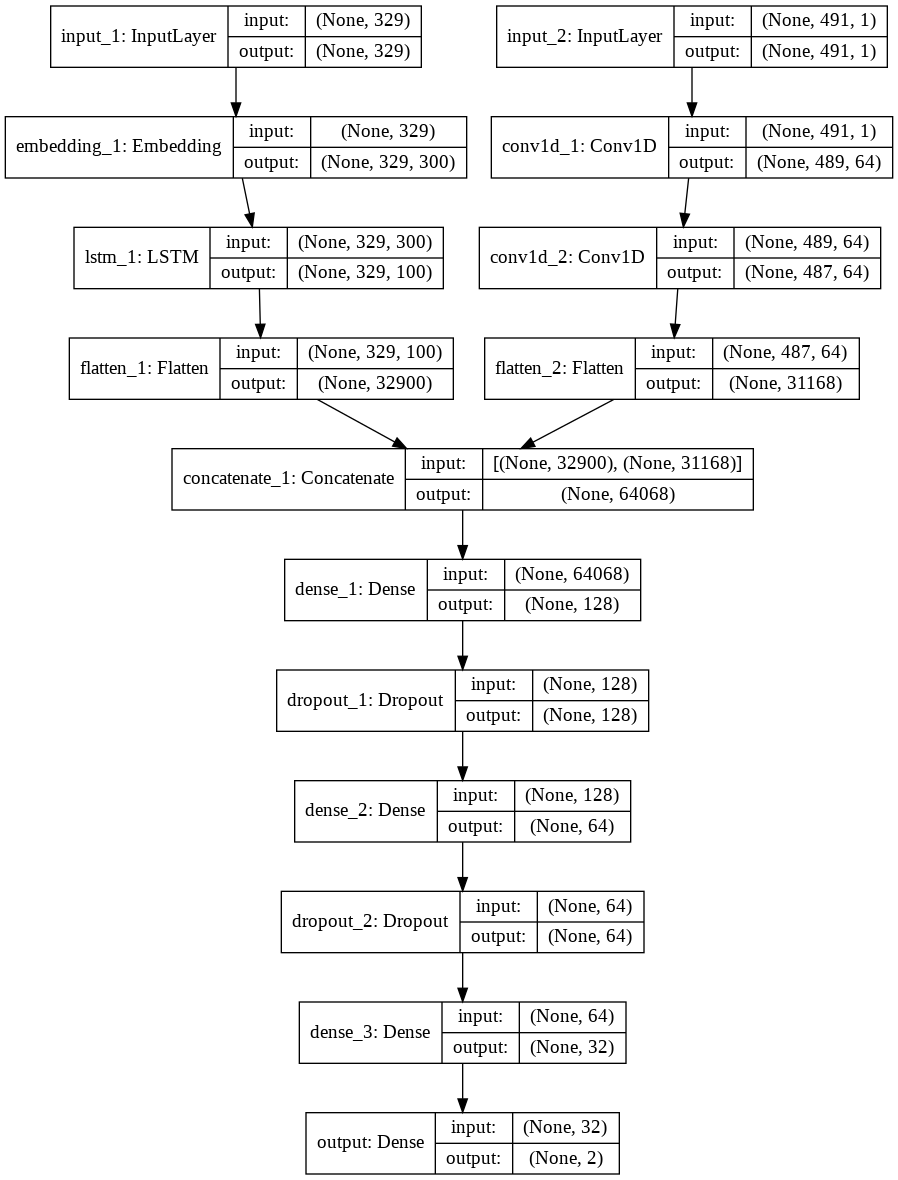

In [141]:
#https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/
from keras.utils.vis_utils import plot_model
plot_model(model_3, to_file='model_3.png', show_shapes=True, show_layer_names=True)

In [0]:
final_data_train=[padded_essay_train,other_train]
final_data_test=[padded_essay_test,other_test]
final_data_cv=[padded_essay_cv,other_cv]

In [0]:
#https://keras.io/callbacks/
#https://www.tensorflow.org/tensorboard/r2/get_started

earlystop_3 = EarlyStopping(monitor = 'val_loss', mode="min",min_delta = 0, patience = 2,verbose = 1,restore_best_weights = True)
tensorboard_3 = TensorBoard(log_dir='direc',histogram_freq=1, batch_size=512, update_freq='epoch')
checkpoint_3 = ModelCheckpoint("model_3.h5",monitor="auc",mode="max",save_best_only = True,verbose=1)

callb3=[tensorboard_3,checkpoint_3,earlystop_3]

In [0]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc])

In [146]:
trained_model = model_3.fit(final_data_train,y_train,batch_size=512,epochs=10,validation_data=(final_data_cv,y_cv),callbacks=callb3)

Train on 53531 samples, validate on 22942 samples
Epoch 1/10
53531/53531 [==============================] - 96s 2ms/step - loss: 0.4718 - auc: 0.6028 - val_loss: 0.4213 - val_auc: 0.7146

Epoch 00001: auc improved from -inf to 0.60277, saving model to model_3.h5
Epoch 2/10
53531/53531 [==============================] - 94s 2ms/step - loss: 0.3977 - auc: 0.7080 - val_loss: 0.4135 - val_auc: 0.7341

Epoch 00002: auc improved from 0.60277 to 0.70804, saving model to model_3.h5
Epoch 3/10
53531/53531 [==============================] - 94s 2ms/step - loss: 0.3808 - auc: 0.7443 - val_loss: 0.3956 - val_auc: 0.7444

Epoch 00003: auc improved from 0.70804 to 0.74433, saving model to model_3.h5
Epoch 4/10
53531/53531 [==============================] - 93s 2ms/step - loss: 0.3641 - auc: 0.7754 - val_loss: 0.3858 - val_auc: 0.7358

Epoch 00004: auc improved from 0.74433 to 0.77542, saving model to model_3.h5
Epoch 5/10
53531/53531 [==============================] - 93s 2ms/step - loss: 0.3441 - a

32775/32775 [==============================] - 20s 603us/step
Test Loss: 0.381044857869341
Test AUC: 0.7289413190959577


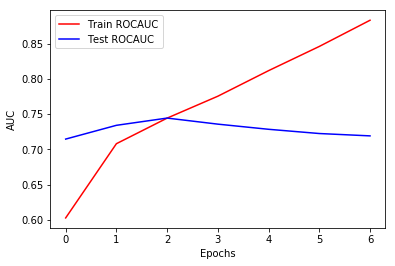

In [147]:
score = model_3.evaluate(final_data_test, y_test, verbose=1,batch_size=512) 
print('Test Loss:', score[0]) 
print('Test AUC:', score[1])

plt.plot(trained_model.history['auc'], 'r')
plt.plot(trained_model.history['val_auc'], 'b')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend({'Train ROCAUC': 'r', 'Test ROCAUC':'b'})

plt.show()

## TEST AUC: 0.73

## GRAPHS FROM TENSORBOARD:-

In [0]:
%tensorboard --logdir direc

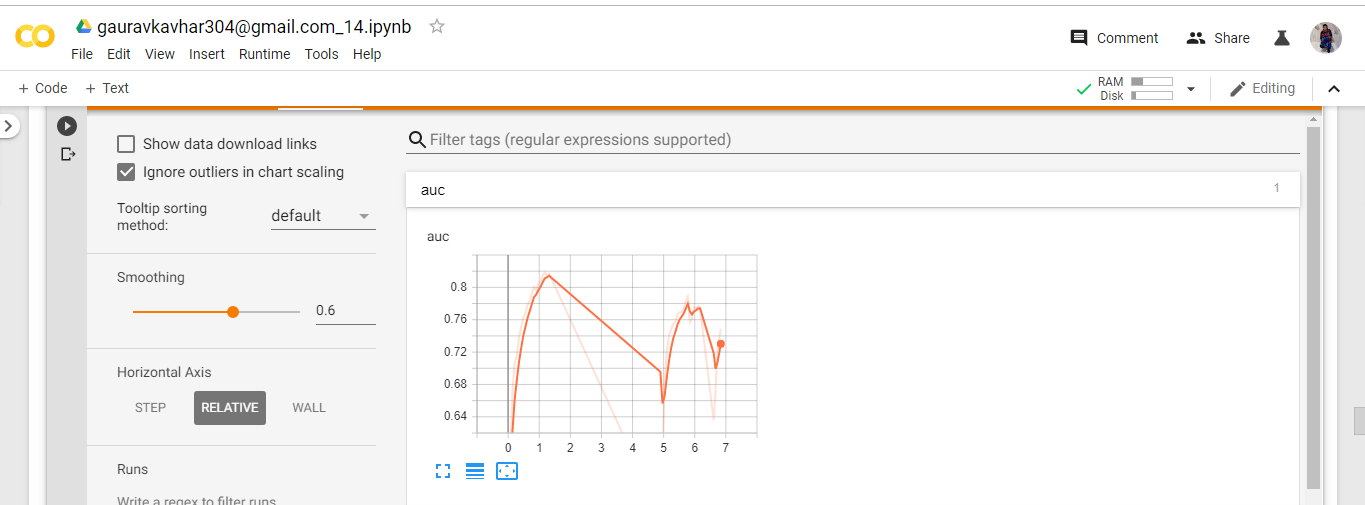

In [23]:
Image('auc3.png')

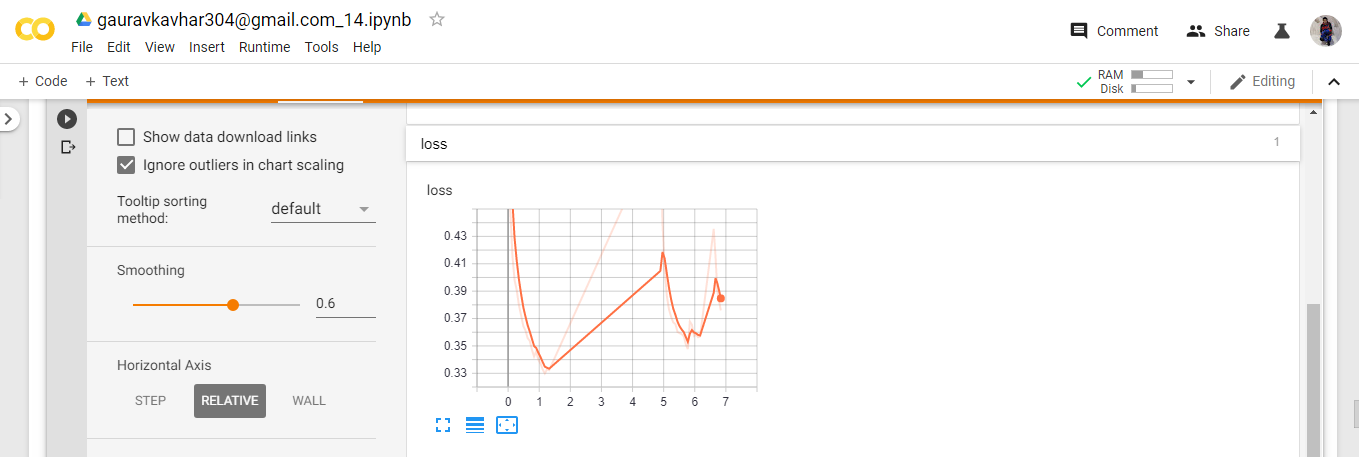

In [24]:
Image('loss3.png')

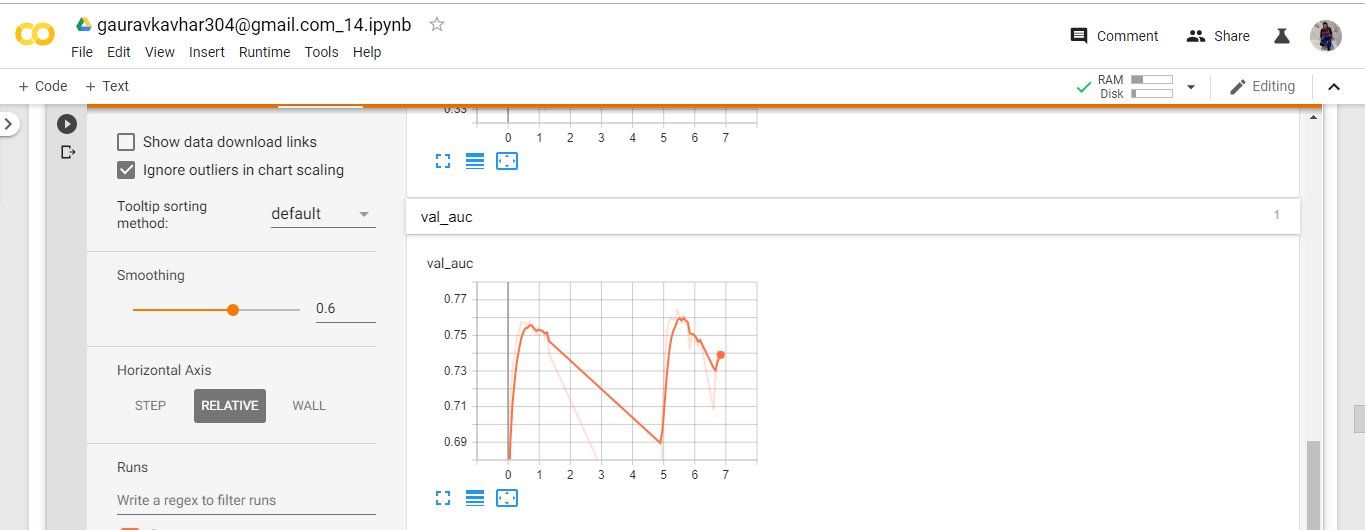

In [26]:
Image('val3.png')

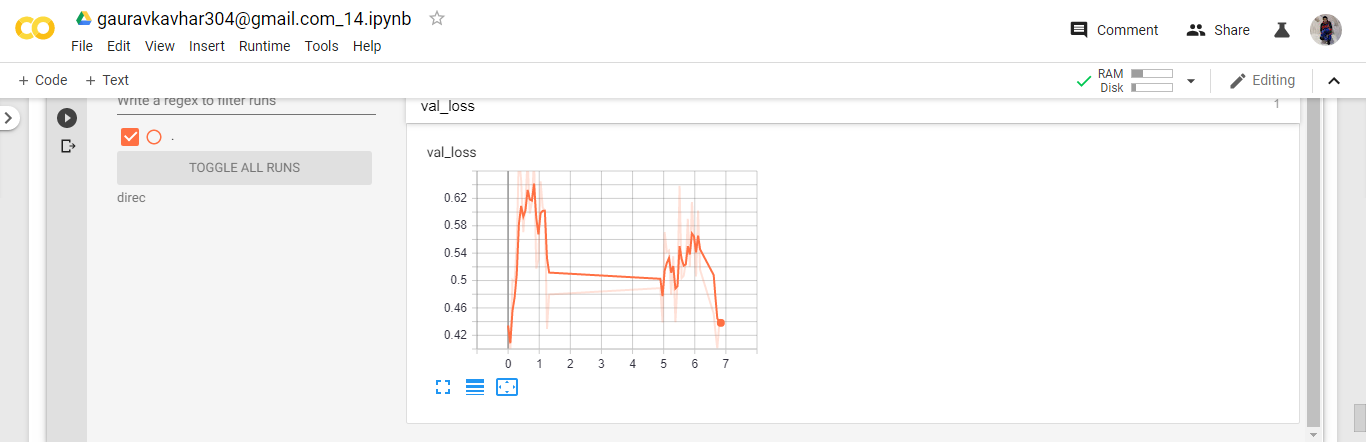

In [27]:
Image('valloss3.png')

# CONCLUSION:

In [28]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Train AUC", "Test AUC"]

x.add_row(["Model 1", 0.80,0.76])
x.add_row(["Model 2", 0.75,0.74])
x.add_row(["Model 3", 0.88,0.73])

print(x)

+---------+-----------+----------+
|  Model  | Train AUC | Test AUC |
+---------+-----------+----------+
| Model 1 |    0.8    |   0.76   |
| Model 2 |    0.75   |   0.74   |
| Model 3 |    0.88   |   0.73   |
+---------+-----------+----------+
